In [ ]:
!pip install datasets transformers albumentations huggingface_hub

In [ ]:
# NEW ALGO #

"""
to deal with inconsistently labelled data
we will train our model on the original data
then we will use the output maps from this model
and combine them with original maps using (logical OR)
then re-train and check results

"""

'\nto deal with inconsistently labelled data\nwe will train our model on the original data\nthen we will use the output maps from this model\nand combine them with original maps using (logical OR)\nthen re-train and check results\n\n'

In [ ]:
from datasets import load_dataset

# v1 is original RGB dataset
# v2 is with some extra preprocessing that was needed for maskformer (not needed in upernet)
# v3 is with RGB + NIR channel dataset (poor performance on this one)

dataset = load_dataset("jaygala223/38-cloud-train-only-v1")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/8400 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 8400
    })
})

In [ ]:
# # exclude bad labels

# bad_labels = [35, 36]

# dataset['train'] = dataset['train'].select(
#     (
#         i for i in range(dataset['train'].num_rows)
#         if i not in set(bad_labels)
#     )
# )

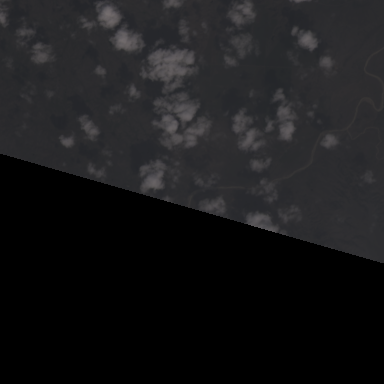

In [ ]:
dataset['train'][35]['image']

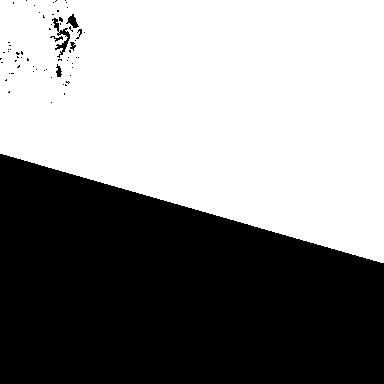

In [ ]:
dataset['train'][35]['label']

In [ ]:
# shuffle + split dataset
# dataset = dataset.shuffle(seed=1)
# dataset = dataset["train"].train_test_split(test_size=0.)
train_ds = dataset["train"]
# test_ds = dataset["test"]

In [ ]:
print(train_ds)
# print(test_ds)

Dataset({
    features: ['image', 'label'],
    num_rows: 8400
})


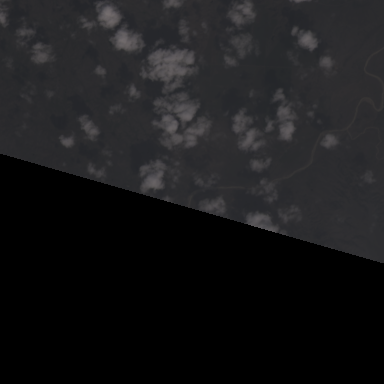

In [ ]:
# let's look at one example
example = train_ds[35]
image = example['image']
image

In [ ]:
import numpy as np
np.array(image).shape

(384, 384, 3)

In [ ]:
import numpy as np

# load corresponding ground truth segmentation map, which includes a label per pixel
segmentation_map = np.array(example['label'])/255
segmentation_map = np.array(segmentation_map, dtype=np.uint8)
segmentation_map

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
np.unique(segmentation_map)

array([0, 1], dtype=uint8)

In [ ]:
from huggingface_hub import hf_hub_download
import json

repo_id = f"jaygala223/38-cloud-train-only-v1"
filename = "id2label.json"
id2label = json.load(open(hf_hub_download(repo_id, filename, repo_type="dataset"), "r"))
id2label = {int(k):v for k,v in id2label.items()}
print(id2label)

{0: 'non-cloud', 255: 'cloud'}


In [ ]:
def color_palette():
    """Color palette that maps each class to RGB values.

    This one is actually taken from ADE20k.
    """
    #since we only have 2 classes
    return [[102, 255, 0], [92, 0, 255]]

palette = color_palette()

In [ ]:
logical_or_map[0][0].shape

NameError: ignored

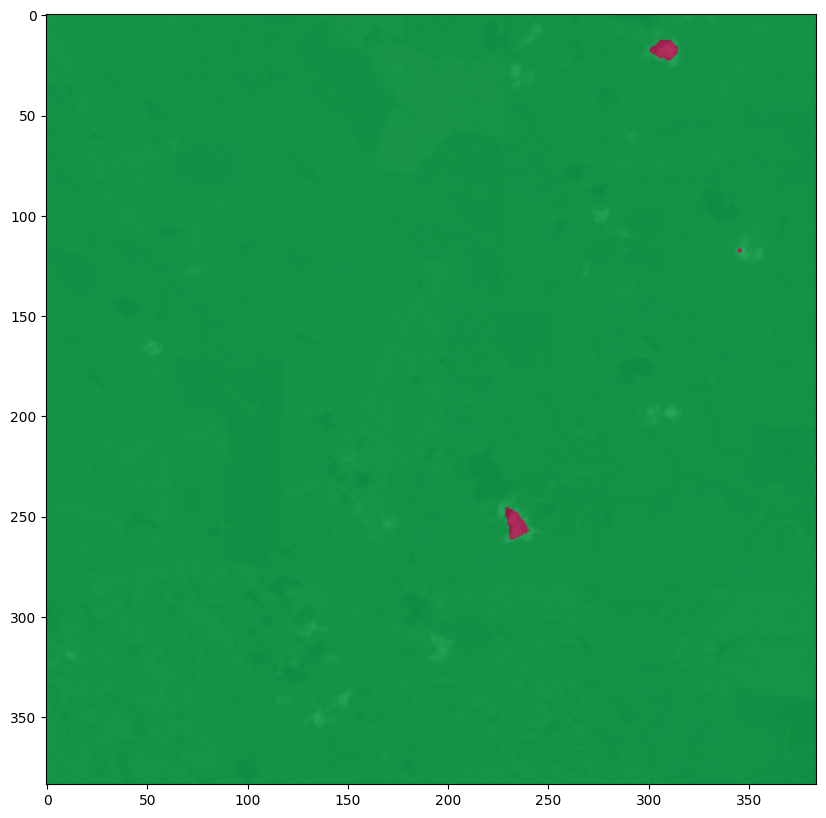

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

color_segmentation_map = np.zeros((logical_or_map[0][0].shape[0], logical_or_map[0][0].shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    color_segmentation_map[logical_or_map[0][0] == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

img = np.array(image) * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

In [ ]:
import numpy as np
from torch.utils.data import Dataset

class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, dataset, transform):
        """
        Args:
            dataset
        """
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        original_image = np.array(self.dataset[idx]['image'])
        original_segmentation_map = np.array(self.dataset[idx]['label'])

        # adding one bottom most pixel as 255 since processor/feature_extractor
        # wont take labels without a positive (i.e. class: 1 or cloud)
        uniques = np.unique(original_segmentation_map)
        if sum(uniques) == 0:
            original_segmentation_map[-1, -1] = 255

        transformed = self.transform(image=original_image, mask=original_segmentation_map)
        image, segmentation_map = transformed['image'], transformed['mask']

        # convert to C, H, W
        image = image.transpose(2,0,1)

        return image, segmentation_map, original_image, original_segmentation_map

In [ ]:
import albumentations as A


ADE_MEAN = np.array([100, 100, 100]) / 255
ADE_STD = np.array([100, 100, 100]) / 255

train_transform = A.Compose([
    # A.LongestMaxSize(max_size=384),
    # A.RandomCrop(width=100, height=100),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

test_transform = A.Compose([
    # A.Resize(width=100, height=100),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

# train_dataset = ImageSegmentationDataset(train_ds)
train_dataset = ImageSegmentationDataset(train_ds, transform=train_transform)
# test_dataset = ImageSegmentationDataset(test_ds, transform=test_transform)
# test_dataset = ImageSegmentationDataset(test_ds)

In [ ]:
# image, segmentation_map, _, _ = train_dataset[0]
image, segmentation_map, _, _ = train_dataset[222]
print(image.shape)
print(segmentation_map.shape)

(3, 384, 384)
(384, 384)


In [ ]:
from transformers import MaskFormerImageProcessor,Mask2FormerImageProcessor, AutoImageProcessor

# Create a preprocessor
# preprocessor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-tiny-ade-semantic",
#                                                   do_reduce_labels=False,
#                                                   do_resize=False, do_rescale=False, do_normalize=False)

size = {'longest_edge':384, 'shortest_edge':384}

#original
preprocessor = MaskFormerImageProcessor(ignore_index=0,
                                        do_reduce_labels=False,
                                        do_resize=False,
                                        do_rescale=False,
                                        do_normalize=False,
                                        size=size)


#my experiment
# preprocessor = Mask2FormerImageProcessor(ignore_index=0, do_reduce_labels=False, do_resize=False, do_rescale=False, do_normalize=False)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    inputs = list(zip(*batch))
    images = inputs[0]
    segmentation_maps = inputs[1]
    # this function pads the inputs to the same size,
    # and creates a pixel mask
    # actually padding isn't required here since we are cropping
    batch = preprocessor(
        images,
        segmentation_maps=segmentation_maps,
        return_tensors="pt",
    )

    batch["original_images"] = inputs[2]
    batch["original_segmentation_maps"] = inputs[3]

    return batch

In [ ]:

# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# batch size more than 2 causes CUDA out of memory error

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn, drop_last=True)
# test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn, drop_last=True)

In [ ]:
import torch

batch = next(iter(train_dataloader))

for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,v[0].shape)

pixel_values torch.Size([1, 3, 384, 384])
pixel_mask torch.Size([1, 384, 384])
mask_labels torch.Size([1, 384, 384])
class_labels torch.Size([1])
original_images (384, 384, 3)
original_segmentation_maps (384, 384)


In [ ]:
from transformers import MaskFormerForInstanceSegmentation, Mask2FormerForUniversalSegmentation

# Replace the head of the pre-trained model

# model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-IN21k-ade-semantic",
#                                                             id2label=id2label,
#                                                             ignore_mismatched_sizes=True)


from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

# feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b3-finetuned-ade-512-512")
# model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b3-finetuned-ade-512-512")

# model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-ade-semantic",
#                                                           id2label=id2label,
#                                                           ignore_mismatched_sizes=True)

# model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-tiny-ade-semantic",
#                                                           id2label=id2label,
#                                                           ignore_mismatched_sizes=True)

og_model = MaskFormerForInstanceSegmentation.from_pretrained("jaygala223/maskformer-finetuned-for-38-cloud-dataset",
                                                          id2label=id2label,
                                                          ignore_mismatched_sizes=True)

# model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-large-coco",
#                                                           id2label=id2label,
#                                                           ignore_mismatched_sizes=True)

In [ ]:
from transformers import MaskFormerFeatureExtractor, MaskFormerForInstanceSegmentation, AutoImageProcessor, UperNetForSemanticSegmentation
from PIL import Image
import requests

size = {'longest_edge':384, 'shortest_edge':383}

# load MaskFormer fine-tuned on COCO panoptic segmentation
feature_extractor = MaskFormerFeatureExtractor.from_pretrained("facebook/maskformer-swin-large-coco",
                                                               size=size,
                                                               )

# model 1 is for generating new pred segmentation maps... model 2 is to train on new pred labels

# image_processor = AutoImageProcessor.from_pretrained("openmmlab/upernet-swin-tiny")
# og_model = UperNetForSemanticSegmentation.from_pretrained("jaygala223/upernet-swin-tiny-finetuned-for-38-cloud-dataset")
# og_model = UperNetForSemanticSegmentation.from_pretrained("openmmlab/upernet-swin-tiny")

/usr/local/lib/python3.10/dist-packages/transformers/models/maskformer/feature_extraction_maskformer.py:28: FutureWarning: The class MaskFormerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use MaskFormerImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/maskformer/image_processing_maskformer.py:411: FutureWarning: The `size_divisibility` argument is deprecated and will be removed in v4.27. Please use `size_divisor` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/maskformer/image_processing_maskformer.py:418: FutureWarning: The `max_size` argument is deprecated and will be removed in v4.27. Please use size['longest_edge'] instead.
  warnings.warn(


In [ ]:
import torch
from torchvision import transforms
from PIL import Image

# Load your PIL image
pil_image = train_ds[36]['image']  # Replace with the path to your image

# Define a transformation to convert PIL image to tensor
transform = transforms.ToTensor()

# Apply the transformation to convert the PIL image to a tensor
tensor_image = transform(pil_image)

In [ ]:
import torch
from torchvision import transforms
from PIL import Image

# Load your PIL image
pil_label = train_ds[36]['label']  # Replace with the path to your image

# Define a transformation to convert PIL image to tensor
transform = transforms.ToTensor()

# Apply the transformation to convert the PIL image to a tensor
tensor_label = transform(pil_label)

tensor_label = tensor_label.unsqueeze(dim=0)

In [ ]:
tensor_image.shape

torch.Size([1, 3, 384, 384])

In [ ]:
og_model.cuda()

inputs = feature_extractor(train_ds[36]['image'], segmentation_maps = train_ds[36]['label'], return_tensors = 'pt')

inputs['mask_labels'] = torch.stack(inputs['mask_labels'])
inputs['class_labels'] = torch.stack(inputs['class_labels'])


inputs.to("cuda")

outputs1 = og_model(**inputs)

print(outputs1.loss)

predicted_map = feature_extractor.post_process_semantic_segmentation(outputs1,
                                                                   target_sizes=[(384,384)])

logical_or_map = torch.logical_or(tensor_label.to("cuda"), predicted_map[0].to("cuda"))

In [ ]:
inputs2 = feature_extractor(train_ds[36]['image'], segmentation_maps = logical_or_map[0], return_tensors = 'pt')

inputs2['mask_labels'] = torch.stack(inputs2['mask_labels'])
inputs2['class_labels'] = torch.stack(inputs2['class_labels'])

inputs2.to("cuda")

outputs2 = og_model(**inputs2)

print(outputs2.loss)

predicted_map2 = feature_extractor.post_process_semantic_segmentation(outputs2,
                                                                   target_sizes=[(384,384)])

logical_or_map = torch.logical_or(logical_or_map.to("cuda"), predicted_map2.to("cuda"))

tensor([0.1195], device='cuda:0', grad_fn=<AddBackward0>)


In [ ]:
print(logical_or_map.float()[0].shape)

torch.Size([384, 384])


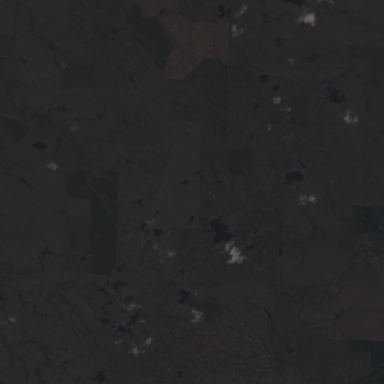

In [ ]:
train_ds[36]['image']

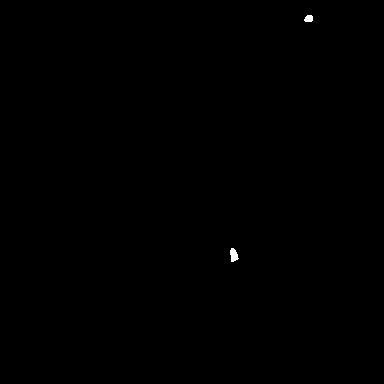

In [ ]:
train_ds[36]['label']

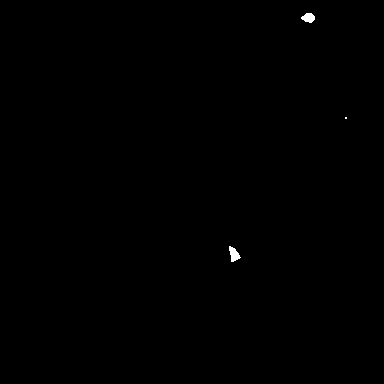

In [ ]:
to_pil = transforms.ToPILImage()
pil_image = to_pil(logical_or_map.float())
pil_image

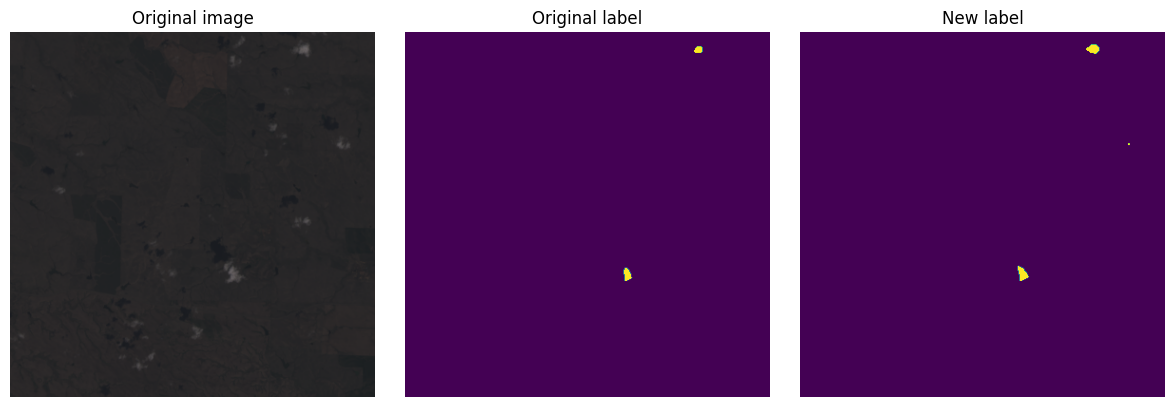

In [ ]:
from PIL import Image

# Load your three PIL images (replace these with your image paths)
image1 = train_ds[36]['image']
image2 = train_ds[36]['label']
image3 = pil_image

# Ensure that all images have the same height
min_height = min(image1.height, image2.height, image3.height)
image1 = image1.crop((0, 0, image1.width, min_height))
image2 = image2.crop((0, 0, image2.width, min_height))
image3 = image3.crop((0, 0, image3.width, min_height))

import matplotlib.pyplot as plt


# Create a figure with three subplots in a row
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Display each image in a subplot
axs[0].imshow(image1)
axs[0].set_title("Original image")
axs[0].axis('off')

axs[1].imshow(image2)
axs[1].set_title("Original label")
axs[1].axis('off')

axs[2].imshow(image3)
axs[2].set_title("New label")
axs[2].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import torch
device = "cpu"
batch = next(iter(train_dataloader))

images, labels = batch['original_images'], batch['original_segmentation_maps']

# first convert to np array then to tensor... because list to tensor is a slow operation
images = np.array(images)
images = torch.tensor(images)/255
# labels = np.array(labels)
# labels = torch.tensor(labels)/255

# image =

# images.to(device)
# labels.to(device)
# og_model.to(device)

# inputs = image_processor(images = images, segmentation_maps = labels, return_tensors = 'pt')

# inputs['mask_labels'] = torch.stack(inputs['mask_labels']).to(device)
# inputs['class_labels'] = torch.stack(inputs['class_labels']).to(device)

# inputs['pixel_values'] = inputs['pixel_values'].float()

# inputs.to(device)
# outputs = og_model(**inputs)

target_sizes1 = [(image.shape[0], image.shape[1]) for image in images]

print(target_sizes1)

# predicted_segmentation_maps1 = image_processor.post_process_semantic_segmentation(outputs1,
#                                                                                   target_sizes=target_sizes1)

# # generate new labels using OR only when the map contains 0s and 1s both
# for label, pred_map in zip(labels, predicted_segmentation_maps1):
#     if len(torch.unique(label)) == 2:
#         label = torch.logical_or(label.to(device), pred_map.to(device))

# # labels = torch.logical_or(labels.to(device), torch.stack(predicted_segmentation_maps1).to(device))

# inputs2 = image_processor(images = images, segmentation_maps = labels, return_tensors = 'pt')

# inputs2.to(device)

# # train on new labels to tackle label inconsistency
# outputs2 = model(**inputs2)

print("done!")

[(384, 384)]
done!


In [ ]:
print(outputs.loss)

tensor(0.0017, grad_fn=<AddBackward0>)


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

TRAINING

In [ ]:
import torch
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cuda"
# model1.to(device)
# model2.to(device)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
scheduler = StepLR(optimizer, step_size=1000, gamma=0.1)

running_loss = 0.0
num_samples = 0
epoch = 0
while True:
  model.train()
  for idx, batch in enumerate(tqdm(train_dataloader)):
      # Reset the parameter gradients
      optimizer.zero_grad()

      images, labels = batch['original_images'], batch['original_segmentation_maps']

      images = np.array(images)
      images = torch.tensor(images)
      labels = np.array(labels)
      labels = torch.tensor(labels)/255

      images.to(device)
      labels.to(device)

      inputs = feature_extractor(images = images, segmentation_maps = labels, return_tensors = 'pt')

      inputs['mask_labels'] = torch.stack(inputs['mask_labels']).to(device)
      inputs['class_labels'] = torch.stack(inputs['class_labels']).to(device)

      inputs['pixel_values'] = inputs['pixel_values'].float()

      inputs.to(device)
      outputs = model(**inputs)

      # Backward propagation
      loss = outputs.loss
      loss.backward()

      batch_size = batch["pixel_values"].size(0)
      running_loss += loss.item()
      num_samples += batch_size

      if idx % 100 == 0:
        print("Loss:", running_loss/num_samples)
        if (running_loss/num_samples) <= 0.10:
            break

      # Optimization
      optimizer.step()

  0%|          | 0/8338 [00:00<?, ?it/s]

Loss: 1.3586831092834473
Loss: 2.71226096477839
Loss: 2.2791294737241756
Loss: 2.4278503484108125
Loss: 2.2825234933684295
Loss: 2.063258994006349
Loss: 2.032742202182776
Loss: 1.9679919593939597
Loss: 1.923470712109898
Loss: 1.8505099324155991
Loss: 1.7912103422990926
Loss: 1.7283017060683057
Loss: 1.6733204721908188
Loss: 1.6339334993523693
Loss: 1.5935026120492852
Loss: 1.554336072265268
Loss: 1.5373404836334488
Loss: 1.522329301850926
Loss: 1.4955842730603173
Loss: 1.4591502801077672
Loss: 1.436746275243254
Loss: 1.4065936404585782
Loss: 1.3870946589259872
Loss: 1.3602132443330537
Loss: 1.337781839305438
Loss: 1.3239201811112102
Loss: 1.308375422431386
Loss: 1.287393379116535
Loss: 1.2728837739353052
Loss: 1.2596458117793816
Loss: 1.2481972142055964
Loss: 1.2487329442639075
Loss: 1.2326320757934057
Loss: 1.2252553907922454
Loss: 1.2138656039416387
Loss: 1.2030694779711975
Loss: 1.188707738026451
Loss: 1.177409901530541
Loss: 1.165636732825415
Loss: 1.1514601799249038
Loss: 1.141897

  0%|          | 0/8338 [00:00<?, ?it/s]

Loss: 0.9854867802232607
Loss: 0.9847401209027263
Loss: 0.9820535141607787
Loss: 0.9790523382101481
Loss: 0.9757272211108189
Loss: 0.9752570506421733
Loss: 0.9720987785323773
Loss: 0.9700757590541765
Loss: 0.967480640885315
Loss: 0.9645365624115901
Loss: 0.962046454709559
Loss: 0.9604922141021389
Loss: 0.9584224453758883
Loss: 0.9554968375930222
Loss: 0.9523658514017472
Loss: 0.9499797129301033
Loss: 0.9482880661029615
Loss: 0.9458847689743933
Loss: 0.9434603797489545
Loss: 0.9410075942446058
Loss: 0.9391153908290264
Loss: 0.9363144676347627
Loss: 0.933892878887139
Loss: 0.931744728324929
Loss: 0.9292406848675074
Loss: 0.9267718031124657
Loss: 0.9255265864215921
Loss: 0.9228757012732323
Loss: 0.921820804405503
Loss: 0.9192366974859361
Loss: 0.9173831063033527
Loss: 0.9149749299063686
Loss: 0.9134255985502033
Loss: 0.9114225994094929
Loss: 0.9089595996194392
Loss: 0.9074889424823609
Loss: 0.9058201699482954
Loss: 0.9037827777574403
Loss: 0.9023105190000892
Loss: 0.9014899713095375
Loss:

  0%|          | 0/8338 [00:00<?, ?it/s]

Loss: 0.8399608687688609
Loss: 0.8385143037646726
Loss: 0.8371924552540047
Loss: 0.8354899993789184
Loss: 0.8337067396671178
Loss: 0.832085368796856
Loss: 0.8307933158005593
Loss: 0.8295389449350039
Loss: 0.8288641080246208
Loss: 0.8275538864030771
Loss: 0.8262676497278689
Loss: 0.8247868397299895
Loss: 0.8236735666265219
Loss: 0.8223044210532543
Loss: 0.8214447500759448
Loss: 0.8203479245101346
Loss: 0.8189474483707847
Loss: 0.8186413186917567
Loss: 0.8170806491942967
Loss: 0.8161122593492287
Loss: 0.8149359375535612
Loss: 0.8137994984951178
Loss: 0.8129130031603884
Loss: 0.8120183003780233
Loss: 0.8120473538519886
Loss: 0.8117486714585196
Loss: 0.810853765702802
Loss: 0.8099756097162374
Loss: 0.8090120674747243
Loss: 0.808805357956727
Loss: 0.8073575856012546
Loss: 0.8063659216799307
Loss: 0.8052584858134343
Loss: 0.8057367106109041
Loss: 0.8049995086655936
Loss: 0.8040565239488872
Loss: 0.80281290620306
Loss: 0.8018093939241517
Loss: 0.801281810287835
Loss: 0.8005317363488105
Loss: 

In [ ]:
repo_name = "maskformer-swin-large-coco-finetuned-for-38-cloud-dataset"
model.push_to_hub(repo_name)

TESTING

In [ ]:
def calculate_iou(pred_mask_list, true_mask_list):
    total_iou = 0.0
    num_masks = len(pred_mask_list)

    for pred_mask, true_mask in zip(pred_mask_list, true_mask_list):
        pred_mask = pred_mask.cpu()
        true_mask = true_mask.cpu()
        intersection = torch.logical_and(pred_mask, true_mask).sum()
        union = torch.logical_or(pred_mask, true_mask).sum()

        iou = intersection.float() / union.float()
        total_iou += iou.item()

    avg_iou = total_iou / num_masks
    return avg_iou

In [ ]:
import torch

def calculate_metrics(true_labels, predicted_labels, device):
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    true_negatives = 0

    for true, predicted in zip(true_labels, predicted_labels):
        true.to(device)
        predicted.to(device)
        true_positives += torch.sum((predicted == 1) & (true == 1)).item()
        false_positives += torch.sum((predicted == 1) & (true == 0)).item()
        false_negatives += torch.sum((predicted == 0) & (true == 1)).item()
        true_negatives += torch.sum((predicted == 0) & (true == 0)).item()

    precision = true_positives / (true_positives + false_positives + 1e-7)
    recall = true_positives / (true_positives + false_negatives + 1e-7)
    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives + 1e-7)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)

    return precision, recall, accuracy, f1_score

# Example usage
true_labels = [torch.tensor([1, 0, 1]), torch.tensor([1, 1, 0])]
predicted_labels = [torch.tensor([1, 0, 1]), torch.tensor([1, 1, 0])]

precision, recall, accuracy, f1_score = calculate_metrics(true_labels, predicted_labels, "cuda")
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1 Score:", f1_score)

Precision: 0.9999999750000006
Recall: 0.9999999750000006
Accuracy: 0.9999999833333336
F1 Score: 0.9999999250000032


In [ ]:
# maskformer evaluation

from tqdm.auto import tqdm

model.eval()
device = "cuda"
all_ious = []
precisions, recalls, accuracies, f1_scores = [], [], [], []
for idx, batch in enumerate(tqdm(test_dataloader)):
    if idx in [5, 10, 25, 50]:
        print(f"IDX {idx}: \n precision", sum(precisions)/ len(precisions))
        print("f1_score", sum(f1_scores)/ len(f1_scores))
        print("recall", sum(recalls)/ len(recalls))
        print("accuracy", sum(accuracies)/ len(accuracies))
        print("mIoU: ", sum(all_ious)/len(all_ious))
    images, labels = batch['original_images'], batch['original_segmentation_maps']

    images = np.array(images)
    images = torch.tensor(images)
    labels = np.array(labels)
    labels = torch.tensor(labels)/255

    images.to(device)
    labels.to(device)

    inputs = feature_extractor(images = images, segmentation_maps = labels, return_tensors = 'pt')

    inputs['mask_labels'] = torch.stack(inputs['mask_labels'])
    inputs['class_labels'] = torch.stack(inputs['class_labels'])

    inputs['pixel_values'] = inputs['pixel_values'].float().to(device)
    inputs.to(device)
    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs)

    target_sizes = [(image.shape[0], image.shape[1]) for image in images]

    predicted_segmentation_maps = feature_extractor.post_process_semantic_segmentation(outputs,
                                                                                  target_sizes=target_sizes)

    for preds in predicted_segmentation_maps:
        preds.int()
        preds.to(device)
    for label in labels:
        label.int()
        label.to(device)

    #for mean iou calculation... pred maps and labels must be same shape
    labels_list = []

    for i in range(labels.size(0)):
        labels[i].int()
        labels_list.append(labels[i].to(device))

#     print(predicted_segmentation_maps, labels_list)
    all_ious.append(calculate_iou(predicted_segmentation_maps, labels_list))
    precision, recall, accuracy, f1_score = calculate_metrics(labels_list, predicted_segmentation_maps, device)
    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)
    f1_scores.append(f1_score)

print("FINAL \n precision", sum(precisions)/ len(precisions))
print("f1_score", sum(f1_scores)/ len(f1_scores))
print("recall", sum(recalls)/ len(recalls))
print("accuracy", sum(accuracies)/ len(accuracies))
print("mIoU: ", sum(all_ious)/len(all_ious))

  0%|          | 0/84 [00:00<?, ?it/s]

IDX 5: 
 precision 0.0
f1_score 0.0
recall 0.0
accuracy 0.6932739257807798
mIoU:  0.0
IDX 10: 
 precision 0.0
f1_score 0.0
recall 0.0
accuracy 0.7181315104161796
mIoU:  0.0
IDX 25: 
 precision 0.0
f1_score 0.0
recall 0.0
accuracy 0.7107185872391015
mIoU:  0.0
IDX 50: 
 precision 0.0
f1_score 0.0
recall 0.0
accuracy 0.6789166937929424
mIoU:  0.0
FINAL 
 precision 0.0
f1_score 0.0
recall 0.0
accuracy 0.6835503956623591
mIoU:  0.0


In [ ]:
# UPERNET evaluation WITH NEW ALGO: LOGICAL OR

from tqdm.auto import tqdm

model2.eval()
device = "cpu"
all_ious = []
precisions, recalls, accuracies, f1_scores = [], [], [], []
for idx, batch in enumerate(tqdm(test_dataloader)):
    if idx > 10:
        break
    images, labels = batch['original_images'], batch['original_segmentation_maps']

    images = np.array(images)
    images = torch.tensor(images)
    labels = np.array(labels)
    labels = torch.tensor(labels)/255

    images.to(device)
    labels.to(device)
    model1.to(device)
    model2.to(device)


    # Forward pass
    with torch.no_grad():
      # forward pass

      inputs1 = image_processor(images = images, segmentation_maps = labels, return_tensors = 'pt')

      inputs1.to(device)

      outputs1 = model1(**inputs1)

      target_sizes1 = [(image.shape[0], image.shape[1]) for image in images]

      predicted_segmentation_maps1 = image_processor.post_process_semantic_segmentation(outputs1,
                                                                                  target_sizes=target_sizes1)

      # generate new labels using OR only when the map contains 0s and 1s both
      for label, pred_map in zip(labels, predicted_segmentation_maps1):
          if len(torch.unique(label)) == 2:
              label = torch.logical_or(label.to(device), pred_map.to(device))

      # labels = torch.logical_or(labels.to(device), torch.stack(predicted_segmentation_maps1).to(device))

      inputs2 = image_processor(images = images, segmentation_maps = labels, return_tensors = 'pt')

      inputs2.to(device)

      # train on new labels to tackle label inconsistency
      outputs2 = model2(**inputs2)


    # get original images
    # original_images = batch["original_images"]
    target_sizes = [(image.shape[0], image.shape[1]) for image in images]
    # predict segmentation maps
    predicted_segmentation_maps = image_processor.post_process_semantic_segmentation(outputs2,
                                                                                  target_sizes=target_sizes)

    for preds in predicted_segmentation_maps:
        preds.int()
        preds.to(device)
    for label in labels:
        label.int()
        label.to(device)


    #for mean iou calculation... pred maps and labels must be same shape
    labels_list = []

    for i in range(labels.size(0)):
        labels[i].int()
        labels_list.append(labels[i])

#     print(predicted_segmentation_maps, labels_list)
    all_ious.append(calculate_iou(predicted_segmentation_maps, labels_list))
    precision, recall, accuracy, f1_score = calculate_metrics(labels_list, predicted_segmentation_maps, device)
    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)
    f1_scores.append(f1_score)

print("precision", sum(precisions)/ len(precisions))
print("f1_score", sum(f1_scores)/ len(f1_scores))
print("recall", sum(recalls)/ len(recalls))
print("accuracy", sum(accuracies)/ len(accuracies))
print("mIoU: ", sum(all_ious)/len(all_ious))

  0%|          | 0/42 [00:00<?, ?it/s]

precision 0.4887262082275274
f1_score 0.5446721992715907
recall 0.8806535562302019
accuracy 0.8276734014951423
mIoU:  0.3576939095018216


In [ ]:
from tqdm.auto import tqdm

model2.eval()
device = "cpu"
all_ious = []
precisions, recalls, accuracies, f1_scores = [], [], [], []
for idx, batch in enumerate(tqdm(test_dataloader)):
    if idx > 10:
        break
    images, labels = batch['original_images'], batch['original_segmentation_maps']

    images = np.array(images)
    images = torch.tensor(images)
    labels = np.array(labels)
    labels = torch.tensor(labels)/255

    images.to(device)
    labels.to(device)
    model2.to(device)

    ### Upernet
    inputs = image_processor(images = images, segmentation_maps = labels, return_tensors = 'pt')

    ### upernet

#     inputs = feature_extractor(images = images, segmentation_maps = labels, return_tensors = 'pt')
#     print(inputs)

    ##### comment these 2 lines for segformer... keep otherwise ####
#     inputs['mask_labels'] = torch.stack(inputs['mask_labels'])
#     inputs['class_labels'] = torch.stack(inputs['class_labels'])
    ##### comment these 2 lines for segformer... keep otherwise ####
#     inputs['pixel_values'] = inputs['pixel_values'].float()
    inputs.to(device)

    # Forward pass
    with torch.no_grad():
      # outputs = model(pixel_values=pixel_values.to(device))
      outputs = model2(**inputs)

    # get original images
    # original_images = batch["original_images"]
    target_sizes = [(image.shape[0], image.shape[1]) for image in images]
    # predict segmentation maps
    predicted_segmentation_maps = image_processor.post_process_semantic_segmentation(outputs,
                                                                                  target_sizes=target_sizes)

#     print(outputs.keys())
    # get ground truth segmentation maps
    # ground_truth_segmentation_maps = batch["original_segmentation_maps"]
    for preds in predicted_segmentation_maps:
        preds.int()
        preds.to(device)
    for label in labels:
        label.int()
        label.to(device)

#     print(predicted_segmentation_maps)
#     print(labels)

    # removing all values into a list of ints because the evaluate library expects it that way.
    labels_for_evaluation = []

    for label in labels:
        labels_for_evaluation.append(label.view(-1))

    labels_for_evaluation = torch.cat(labels_for_evaluation, dim = 0)
    labels_for_evaluation.int()

    pred_labels_for_evaluation = []

    for preds in predicted_segmentation_maps:
        pred_labels_for_evaluation.append(label.view(-1))

    pred_labels_for_evaluation = torch.cat(pred_labels_for_evaluation, dim = 0)
    pred_labels_for_evaluation.int()

    #for mean iou calculation... pred maps and labels must be same shape
    labels_list = []

    for i in range(labels.size(0)):
        labels[i].int()
        labels_list.append(labels[i])

#     print(predicted_segmentation_maps, labels_list)
    all_ious.append(calculate_iou(predicted_segmentation_maps, labels_list))
    precision, recall, accuracy, f1_score = calculate_metrics(labels_list, predicted_segmentation_maps, device)
    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)
    f1_scores.append(f1_score)

print("precision", sum(precisions)/ len(precisions))
print("f1_score", sum(f1_scores)/ len(f1_scores))
print("recall", sum(recalls)/ len(recalls))
print("accuracy", sum(accuracies)/ len(accuracies))
print("mIoU: ", sum(all_ious)/len(all_ious))

  0%|          | 0/42 [00:00<?, ?it/s]

precision 0.4887262082275274
f1_score 0.5446721992715907
recall 0.8806535562302019
accuracy 0.8276734014951423
mIoU:  0.3576939095018216


In [ ]:
# upernet-swin tiny (tuned)
precision 0.9392357746591729
f1_score 0.8274812357961276
recall 0.8020496805250736
accuracy 0.9476910215432391
mIoU:  0.4426152956756679

# upernet-swin tiny (tuned)
precision 0.8683672456144808
f1_score 0.7479758424948
recall 0.7284804817339592
accuracy 0.9722921968707247
mIoU:  0.5187820670279589

# Upernet with LOGICAL OR (OR applied in both training and testing)
At 20% training loss
precision 0.8409011146308205
f1_score 0.8532656625558744
recall 0.8737207014226013
accuracy 0.9673955127443059
mIoU:  0.4893365881659768

At 12% training loss
precision 0.8699746802445684
f1_score 0.8642844356050445
recall 0.8592141353492534
accuracy 0.9738575328476813
mIoU:  0.5058126130395315

At 8% training loss
precision 0.8674168711460868
f1_score 0.8635056062496748
recall 0.8602445691426681
accuracy 0.9734111747353077
mIoU:  0.5060400659726425


# Upernet with LOGICAL OR TWICE(OR applied in both training and testing)
at 40% training loss
precision 0.8800218235572824
f1_score 0.8670481177351661
recall 0.8570141818017505
accuracy 0.9781614361383997
mIoU:  0.512333486567844


# Upernet with LOGICAL OR (OR applied only in training and not in testing)
At 20% training loss
precision 0.8056717629325668
f1_score 0.8335686847209157
recall 0.8731451883300031
accuracy 0.9480223992855058
mIoU:  0.467702101577412

At 12% training loss
precision 0.8366282128662313
f1_score 0.8486793148867103
recall 0.8624495891429831
accuracy 0.9583616931025791
mIoU:  0.4875807930630716


# upernet swin large (untuned)
precision 0.04674390520428237
f1_score 0.05677240963341936
recall 0.07227933222051418
accuracy 0.1463044294935711
mIoU:  0.33444785990053044

#maskformer tuned
precision 0.7754642685034004
f1_score 0.7528422777953474
recall 0.7397811585765738
accuracy 0.9775063871126577
mIoU:  0.7168471569364722

precision 0.5217402294425123
f1_score 0.5894180085336521
recall 0.999999981816197
accuracy 0.5217402294425123
mIoU:  0.521740224174788

* precision 0.3111225918183273
* f1_score 0.3191659886291905
* recall 0.3295510091217397
* accuracy 0.9829524113575062
* mIoU:  0.29805679046190703

* precision 0.26088595055841357
* f1_score 0.29013017962476445
* recall 0.3274049580908574
* accuracy 0.988511827256274
* mIoU:  0.25725841522216797

